In [2]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
from collections import deque
import torch.nn.functional as F

In [3]:
import numpy as np
from collections import deque
from gymnasium import spaces

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.

        Returns lazy array, which is much more memory efficient.

        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.stack(self._frames)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]


def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [4]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DQN_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU()
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 512),  # Flattened CNN features
            nn.ReLU(),
            nn.Linear(512, action_dim)  # Output Q-values for each action
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x

In [5]:
def select_action(env, model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action (exploration)

    state = torch.FloatTensor(state).unsqueeze(0) / 255.0  # Normalize pixels
    state = state.to(device)
    with torch.no_grad():
        return model(state).argmax().item()

def train(model, target_model, buffer, optimizer, batch_size, gamma):
    if buffer.size() < batch_size:
        return

    # Sample batch from experience replay
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    # Compute Q-values for current states
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values of taken actions

    # Compute next Q-values from the target network
    next_q_values = target_model(next_states).max(1)[0].detach()  # Max Q-value of next state

    dones = dones.to(torch.bool)
    # Zero next_q_values for terminal states
    next_q_values[dones] = 0.0

    # Compute target Q-values
    target_q_values = rewards + gamma * next_q_values

    # Compute loss using Huber loss (smooth_l1_loss)
    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()


In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            state,
            action,
            int(reward),
            next_state,
            bool(done)
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixels
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(np.array(next_state)) / 255.0,
            torch.FloatTensor(done)
        )

    def size(self):
        return len(self.buffer)

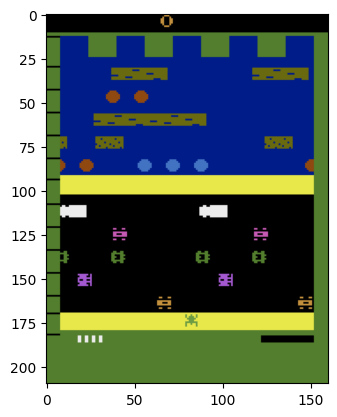

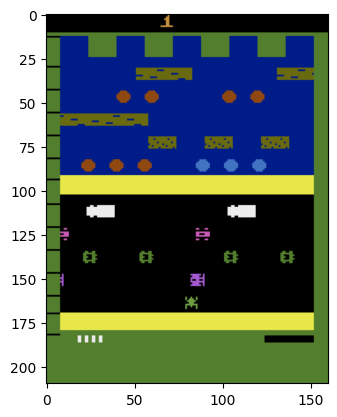

step: 4: reward:1.0
tree len: 4


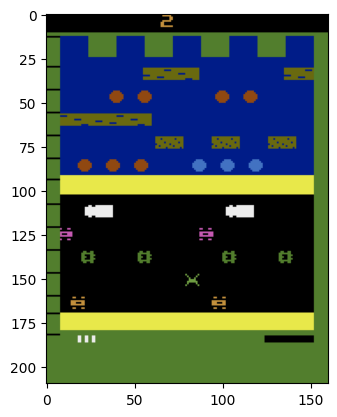

step: 10: reward:2.0
tree len: 9
step: 100


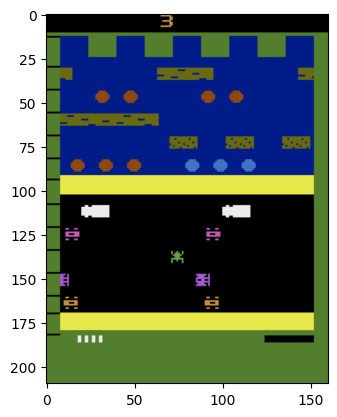

step: 184: reward:3.0
tree len: 148


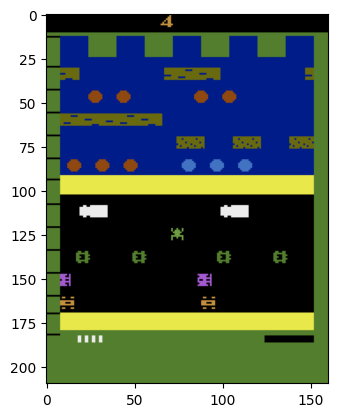

step: 186: reward:4.0
tree len: 149


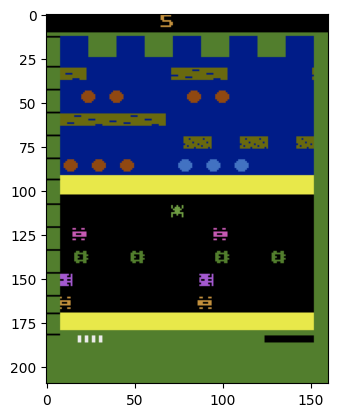

step: 194: reward:5.0
tree len: 156
step: 200


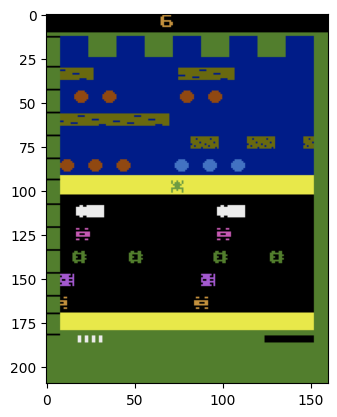

step: 200: reward:6.0
tree len: 1


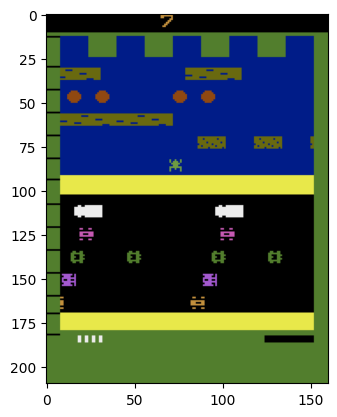

step: 202: reward:7.0
tree len: 2


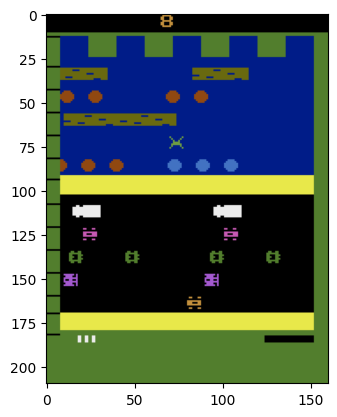

step: 208: reward:8.0
tree len: 7
step: 300
step: 400
step: 500
step: 600
step: 700
step: 800
step: 900
step: 1000
step: 1100
step: 1200
step: 1300
step: 1400
step: 1500
step: 1600
step: 1700
step: 1800
step: 1900
step: 2000
step: 2100
step: 2200
step: 2300
step: 2400
step: 2500
step: 2600
step: 2700
step: 2800
step: 2900
step: 3000
step: 3100
step: 3200
step: 3300
step: 3400
step: 3500
step: 3600
step: 3700
step: 3800
step: 3900
step: 4000
step: 4100
step: 4200
step: 4300
step: 4400
step: 4500
step: 4600
step: 4700
step: 4800
step: 4900
step: 5000
step: 5100
step: 5200
step: 5300
step: 5400
step: 5500
step: 5600
step: 5700
step: 5800
step: 5900
step: 6000
step: 6100
step: 6200
step: 6300
step: 6400
step: 6500
step: 6600
step: 6700
step: 6800
step: 6900
step: 7000
step: 7100
step: 7200
step: 7300
step: 7400
step: 7500
step: 7600
step: 7700
step: 7800
step: 7900
step: 8000
step: 8100
step: 8200
step: 8300
step: 8400
step: 8500
step: 8600
step: 8700
step: 8800
step: 8900
step: 9000
step:

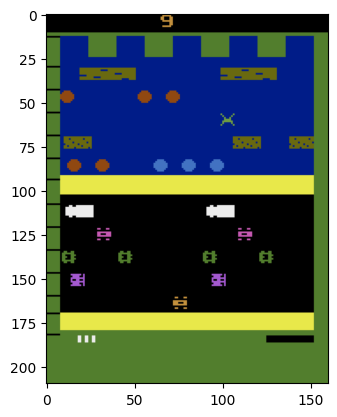

step: 13685: reward:9.0
tree len: 10789
step: 13700
step: 13800
step: 13900
step: 14000
step: 14100
step: 14200
step: 14300
step: 14400
step: 14500
step: 14600
step: 14700
step: 14800
step: 14900
step: 15000
step: 15100
step: 15200
step: 15300
step: 15400
step: 15500
step: 15600
step: 15700
step: 15800
step: 15900
step: 16000
step: 16100
step: 16200
step: 16300
step: 16400
step: 16500
step: 16600
step: 16700
step: 16800
step: 16900
step: 17000
step: 17100
step: 17200
step: 17300
step: 17400
step: 17500
step: 17600
step: 17700
step: 17800
step: 17900
step: 18000
step: 18100
step: 18200
step: 18300
step: 18400
step: 18500
step: 18600
step: 18700
step: 18800
step: 18900
step: 19000
step: 19100
step: 19200
step: 19300
step: 19400
step: 19500
step: 19600
step: 19700
step: 19800
step: 19900
step: 20000
step: 20100
step: 20200
step: 20300
step: 20400
step: 20500
step: 20600
step: 20700
step: 20800
step: 20900
step: 21000
step: 21100
step: 21200
step: 21300
step: 21400
step: 21500
step: 21600


KeyboardInterrupt: 

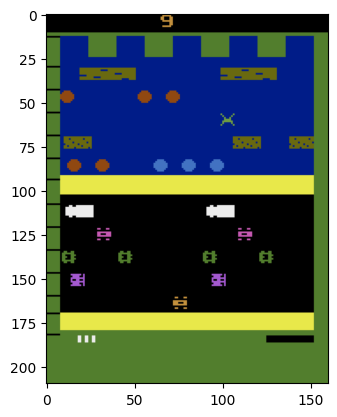

In [17]:
# Create the Atari environment
import copy
from collections import deque
import random

env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")  # Create Atari env
# env = GrayscaleObservation(env, keep_dim=False)
# env = ResizeObservation(env, (84, 84))
# env = wrap_deepmind(env, episode_life=False, clip_rewards=False, frame_stack=True, scale=False)

# Check Action / State space
state, info = env.reset()

action_dim = env.action_space.n

img = env.render()
clear_output(wait=False)
plt.imshow(img)
display(plt.gcf())

# Prepare environment past ignored steps
ignore_steps = 125
for i in range(ignore_steps):
    next_state, reward, done, truncated, info = env.step(0)

# game_state = env.unwrapped.clone_state(include_rng=True)
# env2 = gym.make("ALE/Frogger-v5", render_mode="rgb_array").unwrapped
# env2.restore_state(game_state)

# next_state, reward, done, truncated, info = env2.step(np.int64(1))
# next_state, reward, done, truncated, info = env2.step(np.int64(0))

# img = env2.render()
# clear_output(wait=False)
# plt.imshow(img)
# display(plt.gcf())

max_reward = 0
max_steps = 20
NUM_LIVES = 4

def rec_search(next_env, cur_reward, next_action):
    game_state = next_env.unwrapped.clone_state(include_rng=True)
    temp_env = gym.make("ALE/Frogger-v5", render_mode="rgb_array").unwrapped
    temp_env.restore_state(game_state)
    
    next_state, reward, done, truncated, info = temp_env.step(np.int64(next_action))
    cur_reward += reward
    next_state, reward, done, truncated, info = temp_env.step(np.int64(0))
    cur_reward += reward

    alive = True if NUM_LIVES == 4 else False

    return temp_env, cur_reward, alive

tree = deque([(env,0)])
step = 0
# Begin the search 

while max_reward < 50:

    next_env, cur_reward = tree.pop()

    actions = list(range(0,5))
    random.shuffle(actions)
    # shuffled = random.shuffle(actions)
    for next_action in actions:

        step += 1

        if step % 100 == 0:
            print(f"step: {step}")

        new_env, new_rew, alive = rec_search(next_env, cur_reward, next_action)

        if not alive:
            continue

        if new_rew > max_reward:
            max_reward = new_rew

            tree.append((new_env, new_rew))

            # reset tree at 6 since at sandbar
            if new_rew == 6:
                tree = deque([(new_env, new_rew)])

            img = new_env.render()
            plt.imshow(img)
            display(plt.gcf())
            print(f"step: {step}: reward:{max_reward}")
            print(f"tree len: {len(tree)}")

        else:
            tree.appendleft((new_env, new_rew))
    